### Analysis of trained models

This notenook can be used to perform basic analysis of our models : 
- explore the latent space like in Schmidhuber world model paper.
- look at different SPE metric for 4 different disruptions of "flow" : position glitch, digit identity glitch, speed glitch & effect of bouncing. 

In [1]:
%matplotlib inline
import numpy as np
import random
import torch 
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import yaml
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 300
import ipywidgets as widgets
from ipywidgets import FloatSlider, IntSlider, interactive_output, HBox, Layout


# we want to use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

import sys
sys.path.append("../models")
from vae_64_64 import VAE_64_64
from mdrnn import MDRNN
from vrnn import VRNN

sys.path.append("../utils")
from plot_functions import plot_video_comparison,plot_SPE_metrics


cuda


In [2]:
# import data from the moving mnist dataset
data_sequential = np.load('../../data/MNIST/bouncing_mnist_test.npy')
data_sequential = data_sequential / 255
data = data_sequential.reshape((200000,1,64,64)) # we split the 10000 video of 20 frames into 200000 images of 64x64 pixels

### VAE module

In [3]:
vae_model_path = '../../saved_models/MNIST/model_vae_2023-05-04.pt'
vae_params_path_recovery = vae_model_path[:-3]+'.params.yml'
with open(vae_params_path_recovery) as file :
    vae_parameters = yaml.load(file,Loader=yaml.FullLoader)
print('using parameters from '+vae_params_path_recovery)

vae_model = VAE_64_64(img_channels=vae_parameters['img_channels_vae'],
                     latent_dim=vae_parameters['latent_dim_vae'],
                     beta=vae_parameters['beta_vae']).to(device)

vae_model.load_state_dict(torch.load(vae_model_path))
vae_model.eval()

using parameters from ../../saved_models/MNIST/model_vae_2023-05-04.params.yml


VAE_64_64(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (fc_mu): Linear(in_features=1024, out_features=20, bias=True)
    (fc_logsigma): Linear(in_features=1024, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=20, out_features=256, bias=True)
    (deconv1): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2))
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (deconv3): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (deconv4): ConvTranspose2d(32, 1, kernel_size=(6, 6), stride=(2, 2))
  )
)

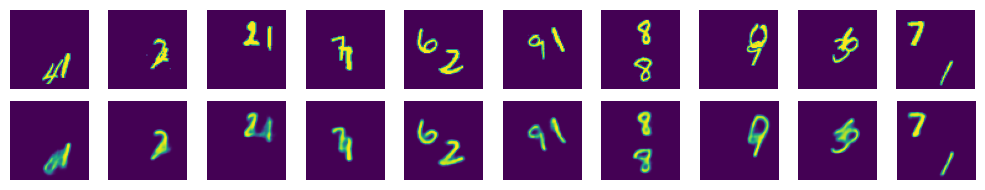

In [4]:
imgs = np.array(random.sample(list(data), 10))
imgs_tensor = torch.tensor(imgs).to(device).float()
out_tensor, mu, logsigma = vae_model(imgs_tensor)
out = out_tensor.cpu().detach().numpy()

plot_video_comparison(imgs.squeeze(1),out.squeeze(1))


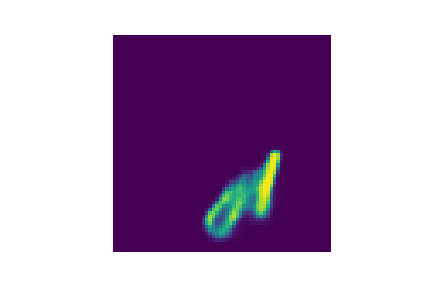

In [5]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

def plot_latent(**kwargs):
    """
    Print the current widget value in short sentence
    """
    z = []
    for z_i in locals()['kwargs']:
        z.append(locals()['kwargs'][z_i])
    z = torch.tensor(z).unsqueeze(0).float().to(device)
    out = vae_model.decoder_pass(z)
    outimg = np.transpose(out[0].cpu().detach().numpy(), [1,2,0])
    ax.imshow(np.squeeze(outimg))
    ax.set_axis_off()
    fig.canvas.draw()
    
latent_dim = mu.shape[1]
latent_variables_init = {}
for i in range(latent_dim):
    latent_variables_init["z_"+str(i)] = mu[0,i].cpu().detach().item()
w = widgets.interactive(plot_latent,**latent_variables_init)
for slider in w.children:
    slider.min = -4
    slider.max = 4
    slider.orientation='vertical'
    slider.layout = Layout(width='90%')

display(HBox(w.children))



### Full "world model"

In [6]:
mdrnn_model_path = '../../saved_models/MNIST/model_mdrnn_2023-05-04.pt'
mdrnn_params_path_recovery = mdrnn_model_path[:-3]+'.params.yml'
with open(mdrnn_params_path_recovery) as file :
    mdrnn_parameters = yaml.load(file,Loader=yaml.FullLoader)
print('using parameters from '+mdrnn_params_path_recovery)

mdrnn_model = MDRNN(latent_dim=mdrnn_parameters['latent_dim_mdrnn'],
            action_dim=mdrnn_parameters['action_dim_mdrnn'],
            hidden_dim=mdrnn_parameters['hidden_dim_mdrnn'],
            gaussians_nb=mdrnn_parameters['gaussians_nb_mdrnn']).to(device)
mdrnn_model.load_state_dict(torch.load(mdrnn_model_path))
mdrnn_model.eval()

using parameters from ../../saved_models/MNIST/model_mdrnn_2023-05-04.params.yml


MDRNN(
  (gmm_linear): Linear(in_features=128, out_features=41, bias=True)
  (rnn): RNN(22, 128)
)

In [7]:
def run_model_prediction(video):
    video = np.transpose(video,(1,0,2,3))
    seq_len,batch_size,_,_ = video.shape
    video_tensor = torch.reshape(torch.tensor(video).float(),(-1,1,64,64)).float().to(device)
    reconstructed_video,latent_video, latent_video_variance  = vae_model(video_tensor)
    latent_dim = latent_video.shape[-1]
    latent_video = torch.reshape(latent_video,(seq_len,batch_size,latent_dim))
    latent_video_variance = torch.reshape(latent_video_variance,(seq_len,batch_size,latent_dim))
    reconstructed_video = torch.reshape(reconstructed_video,(seq_len,batch_size,64,64))

    if mdrnn_model.memory == 'rnn':
        hidden = torch.zeros(batch_size, mdrnn_model.hidden_dim).to(device)
    else :
        hidden = (torch.zeros(batch_size, mdrnn_model.hidden_dim).to(device),
                        torch.zeros(batch_size, mdrnn_model.hidden_dim).to(device))
    action = torch.zeros(batch_size, 2).to(device)

    mean_pred = []
    sig_pred = []
    for t in range(seq_len):

        latent = latent_video[t,:,:]

        if mdrnn_model.memory == 'rnn':
            mus, sigmas, logpi, next_hidden = mdrnn_model(action,latent,hidden)
            hidden = next_hidden[1].squeeze(0)
        else :
            mus, sigmas, logpi, next_hidden = mdrnn_model(action,latent,hidden)
            hidden = next_hidden

        mean_pred.append(mus[:,0,:].cpu().detach().numpy())
        sig_pred.append(sigmas[:,0,:].cpu().detach().numpy())

    mean_pred = np.array(mean_pred).transpose(1,0,2)
    sig_pred = np.array(sig_pred).transpose(1,0,2)
    latent_video = latent_video.cpu().detach().numpy().transpose(1,0,2)
    latent_video_variance = np.exp(latent_video_variance.cpu().detach().numpy()).transpose(1,0,2)
    reconstructed_video = reconstructed_video.cpu().detach().numpy().transpose(1,0,2,3)
    
    return reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred

In [8]:
random_index_1 = np.random.randint(10000,size=100)
random_index_2 = np.random.randint(10000,size=100)
video = data_sequential[random_index_1,:]
index_shuffle = [list(np.random.randint(10,size=10)) for i in range(300)]

video = np.concatenate((data_sequential[random_index_1,:10],data_sequential[random_index_2,:10]),axis=1) 

reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred = run_model_prediction(video)

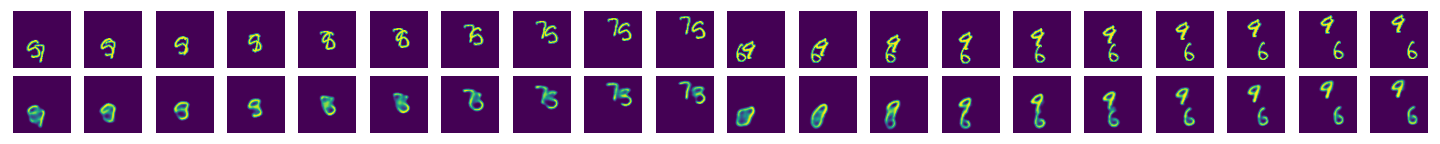

In [9]:
plot_video_comparison(video[0],reconstructed_video[0])

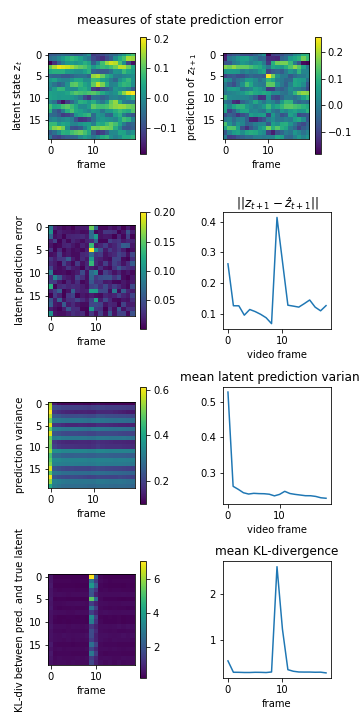

In [10]:
plot_SPE_metrics(latent_video, latent_video_variance, mean_pred, sig_pred)

In [14]:
data_path = "../../data/MNIST/"
data_files = [
    "standard.npy", 
    "random_position_glitch.npy",
    "offset_position_glitch.npy",
    "digit_glitch.npy",
    "position_and_digit_glitch.npy",
    "reverse_direction_glitch.npy",
    "random_direction_glitch.npy",
    "speed_glitch.npy",
    "timed_bounce.npy",
]

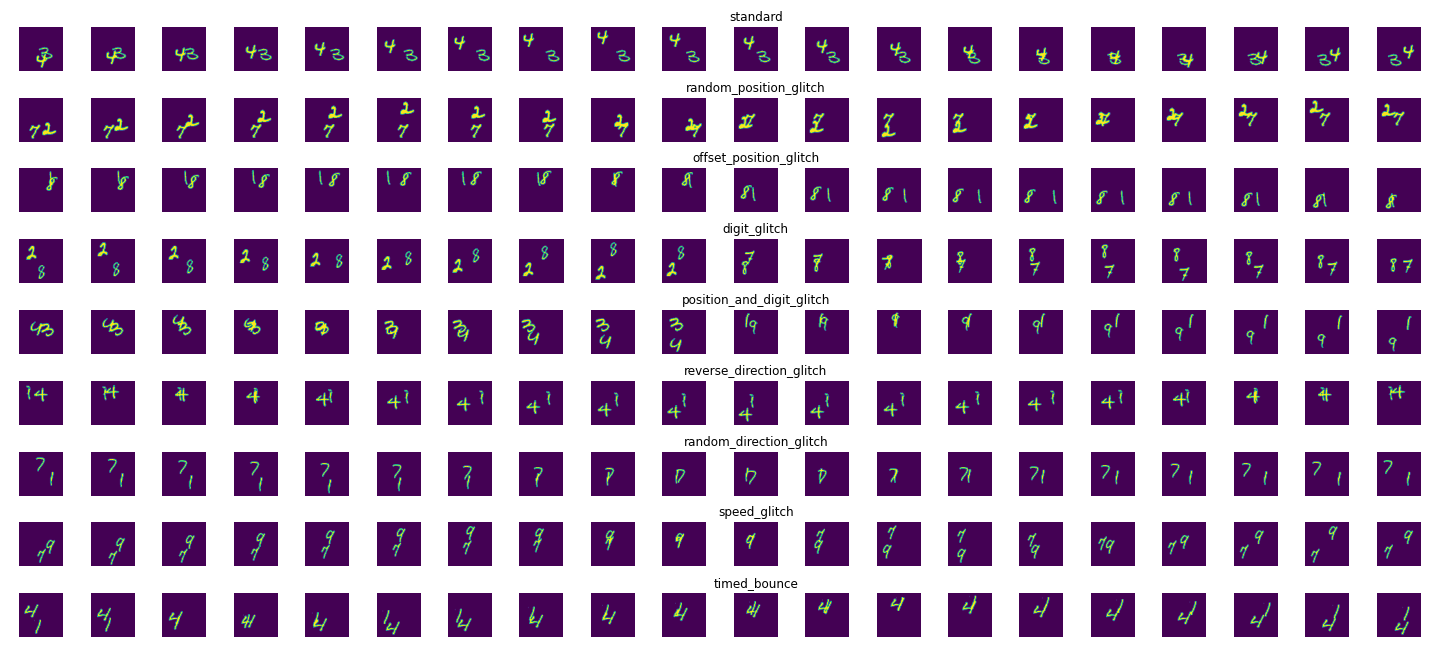

In [15]:
fig, axs = plt.subplots(len(data_files),20,figsize=(20,len(data_files)))

for i, (file,axs_file) in enumerate(zip(data_files,axs)):
    data = np.load(data_path + file)
    video = data[np.random.randint(100)]
    axs_file[10].set_title(file.split(".")[0])

    for frame, ax in enumerate(axs_file):
        ax.imshow(video[frame,:,:])
        ax.axis('off')

fig.tight_layout()
plt.show()

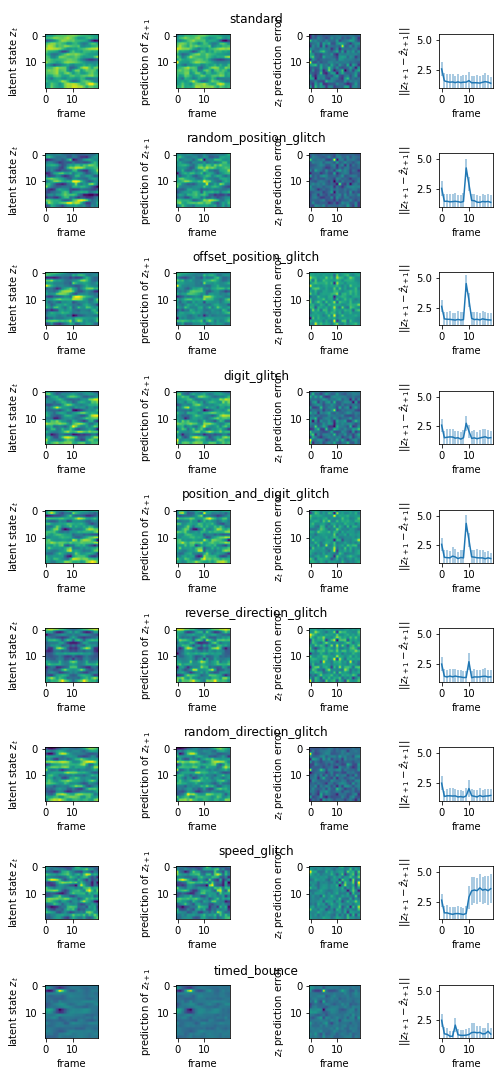

In [16]:
import scipy.stats

fig, axs = plt.subplots(len(data_files),4,figsize=(7,15))

for i, (file,axs_file) in enumerate(zip(data_files,axs)):
    data = np.load(data_path + file)
    data = data / 255
    reconstructed_video,latent_video, latent_video_variance, mean_pred, sig_pred = run_model_prediction(data)

    z = np.mean(latent_video,axis=0).T
    z_pred = np.mean(mean_pred,axis=0).T

    array = mean_pred[:,:-1,:] -  latent_video[:,1:,:]

    # first measure of SPE : norm between z_t and mean of P(z_t|h_t-1)
    z_error = np.mean(mean_pred[:,:-1,:] - latent_video[:,1:,:],axis=0).T

    z_error_norm = np.mean( np.linalg.norm(array,axis=-1) ,axis=0) # first we compute the norm || z_t+1 , z_t || for every t and every sequence (100,19,32) => (100,19) and then we average it across sequences (100,19) => (,19)

    err = np.std(np.linalg.norm(array,axis=-1),axis=0)

    axs_file[1].set_title(file.split(".")[0],x=1.5, y=1.1)

    axs_file[0].imshow(z)
    axs_file[0].set_xlabel('frame')
    axs_file[0].set_ylabel(r'latent state $z_{t}$')

    axs_file[1].imshow(z_pred)
    axs_file[1].set_xlabel('frame')
    axs_file[1].set_ylabel(r'prediction of $z_{t+1}$ ')

    axs_file[2].imshow(z_error)
    axs_file[2].set_xlabel('frame')
    axs_file[2].set_ylabel(r'$z_t$ prediction error')

    axs_file[3].plot(z_error_norm)
    axs_file[3].set_xlabel('frame')
    axs_file[3].set_ylabel(r'$||z_{t+1} - ẑ_{t+1}||$')
    axs_file[3].errorbar(range(z_error_norm.shape[0]), z_error_norm, err, linestyle='None', color = 'tab:blue',alpha=0.5)
    axs_file[3].set_ylim([1,5.5])
    
fig.tight_layout()
plt.show()